# Refine Positive genes

Gaol: postive gesn form tpevios stesp are too broad, a methodd to reifne them is needed.

Idea: 
- find cells in the cycicling prcess
    - use geneset scores to find thme
- use rpevius psotive genes set asa progrma and find if these ghenes are expressed ....

In [56]:
# Autorelaod
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scanpy as sc
os.chdir("/home/gdallagl/myworkdir/ESMSec")
print(f"Working directory successfully changed to: {os.getcwd()}")

import utils.my_functions as mf
import utils.dataset_functions as dataf

config_file="/home/gdallagl/myworkdir/ESMSec/config/config.yaml"
config = mf.load_config(config_file)

mf.set_all_seeds(config["random_seed"])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Working directory successfully changed to: /home/gdallagl/myworkdir/ESMSec
Seeds set successfully to 42 for random, numpy, and PyTorch (if used).


# Load datset

In [94]:
data_dir = config["data_paths"]["neftel_data_folder"]

# Load the matrix (Cell by Gene, or Gene by Cell, default is usually gene x cell)
adata = sc.read_mtx(os.path.join(data_dir, 'Exp_data_UMIcounts.mtx')).T # Transpose to get Cell x Gene

# 2. Read feature names (genes) and barcodes (cells)
genes = pd.read_csv(os.path.join(data_dir, 'Genes.txt'), header=None, names=["gene"], sep='\t')
display(genes.head(2))
cells = pd.read_csv(os.path.join(data_dir, 'Cells.csv'), index_col=0)
display(cells.head(2))

# 3. Assign cell and gene names to the AnnData object
# Note: Ensure the order matches the matrix. The .T above ensures cells are rows and genes are columns.
adata.obs_names = cells.index.astype(str)
adata.var_names = genes.gene.astype(str)

# 4. Read Cell metadata and add to .obs (cell annotations)
cell_meta = pd.read_csv(os.path.join(data_dir, 'Cells.csv'), index_col=0)
adata.obs = cell_meta.loc[adata.obs_names] # Align indices

# ATTENTION: makes genes unqiuie
adata.var_names_make_unique()
print("Are genes unique?", adata.var_names.is_unique)

# ATTETION: remove cells wiht at least 1 None in metadata
adata = adata[~adata.obs[["cell_cycle_phase"]].isna().any(axis=1)].copy()

print("Data Loaded:")
display(adata.obs)
display(adata.obs.columns)

# check data structure
X = adata.X.toarray()
print("Is data raw of log normalised?")
print("min, max", np.min(adata.X), np.max(adata.X))
print(X[X > 0][:20]) 
print("Has gene ecpression been centered?")
gene_means = np.array(X.mean(axis=0)).ravel()
print("Mean expression per gene (first 10):", gene_means[:10])
print("Overall mean of gene means:", gene_means.mean())

,gene
0,FAM138A
1,OR4F5


,sample,cell_type,complexity,umap1,umap2,g1s_score,g2m_score,cell_cycle_phase,mp_top_score,mp_top,mp_assignment
cell_name,,,,,,,,,,,
102_1,102,Malignant,3101,20.8435,-12.0361,-0.0434,0.1245,Not cycling,1.1889,Oligo Progenitor,Oligo Progenitor
102_2,102,Malignant,2366,-12.6327,-18.9353,1.1051,0.2308,G1/S,1.4424,Cell Cycle - G1/S,Cell Cycle - G1/S


Are genes unique? True
Data Loaded:


,sample,cell_type,complexity,umap1,umap2,g1s_score,g2m_score,cell_cycle_phase,mp_top_score,mp_top,mp_assignment
cell_name,,,,,,,,,,,
102_1,102,Malignant,3101,20.8435,-12.0361,-0.0434,0.1245,Not cycling,1.1889,Oligo Progenitor,Oligo Progenitor
102_2,102,Malignant,2366,-12.6327,-18.9353,1.1051,0.2308,G1/S,1.4424,Cell Cycle - G1/S,Cell Cycle - G1/S
102_4,102,Malignant,1217,-11.9102,-18.0864,-0.1774,-0.0561,Not cycling,1.4340,Stress,NaN
102_5,102,Malignant,2285,20.1392,-11.5944,-0.1211,-0.0473,Not cycling,2.6042,Oligo Progenitor,Oligo Progenitor
102_7,102,Malignant,1725,17.2946,-16.4965,-0.0337,-0.0467,Not cycling,1.5445,NPC Glioma,NPC Glioma
...,...,...,...,...,...,...,...,...,...,...,...
105_D2_139,105,Malignant,1029,28.8941,9.4308,-0.2548,-0.0581,Not cycling,4.9770,Oligo normal,NaN
105_D2_148,105,Malignant,1035,29.0623,9.6065,-0.2660,-0.0584,Not cycling,5.2820,Oligo normal,NaN
105_D2_189,105,Macrophage,1126,-20.2338,8.0329,-0.0252,0.0550,Not cycling,1.0727,MAC3,MAC3


Index(['sample', 'cell_type', 'complexity', 'umap1', 'umap2', 'g1s_score',
       'g2m_score', 'cell_cycle_phase', 'mp_top_score', 'mp_top',
       'mp_assignment'],
      dtype='object')

Is data raw of log normalised?
min, max 0.0 9814.0
[2. 1. 2. 2. 3. 1. 1. 1. 1. 1. 4. 1. 1. 2. 2. 3. 4. 4. 1. 4.]
Has gene ecpression been centered?
Mean expression per gene (first 10): [0.0000000e+00 0.0000000e+00 3.4825003e-03 8.7062508e-05 0.0000000e+00
 0.0000000e+00 4.4532475e-01 9.1415634e-03 0.0000000e+00 0.0000000e+00]
Overall mean of gene means: 0.39999026


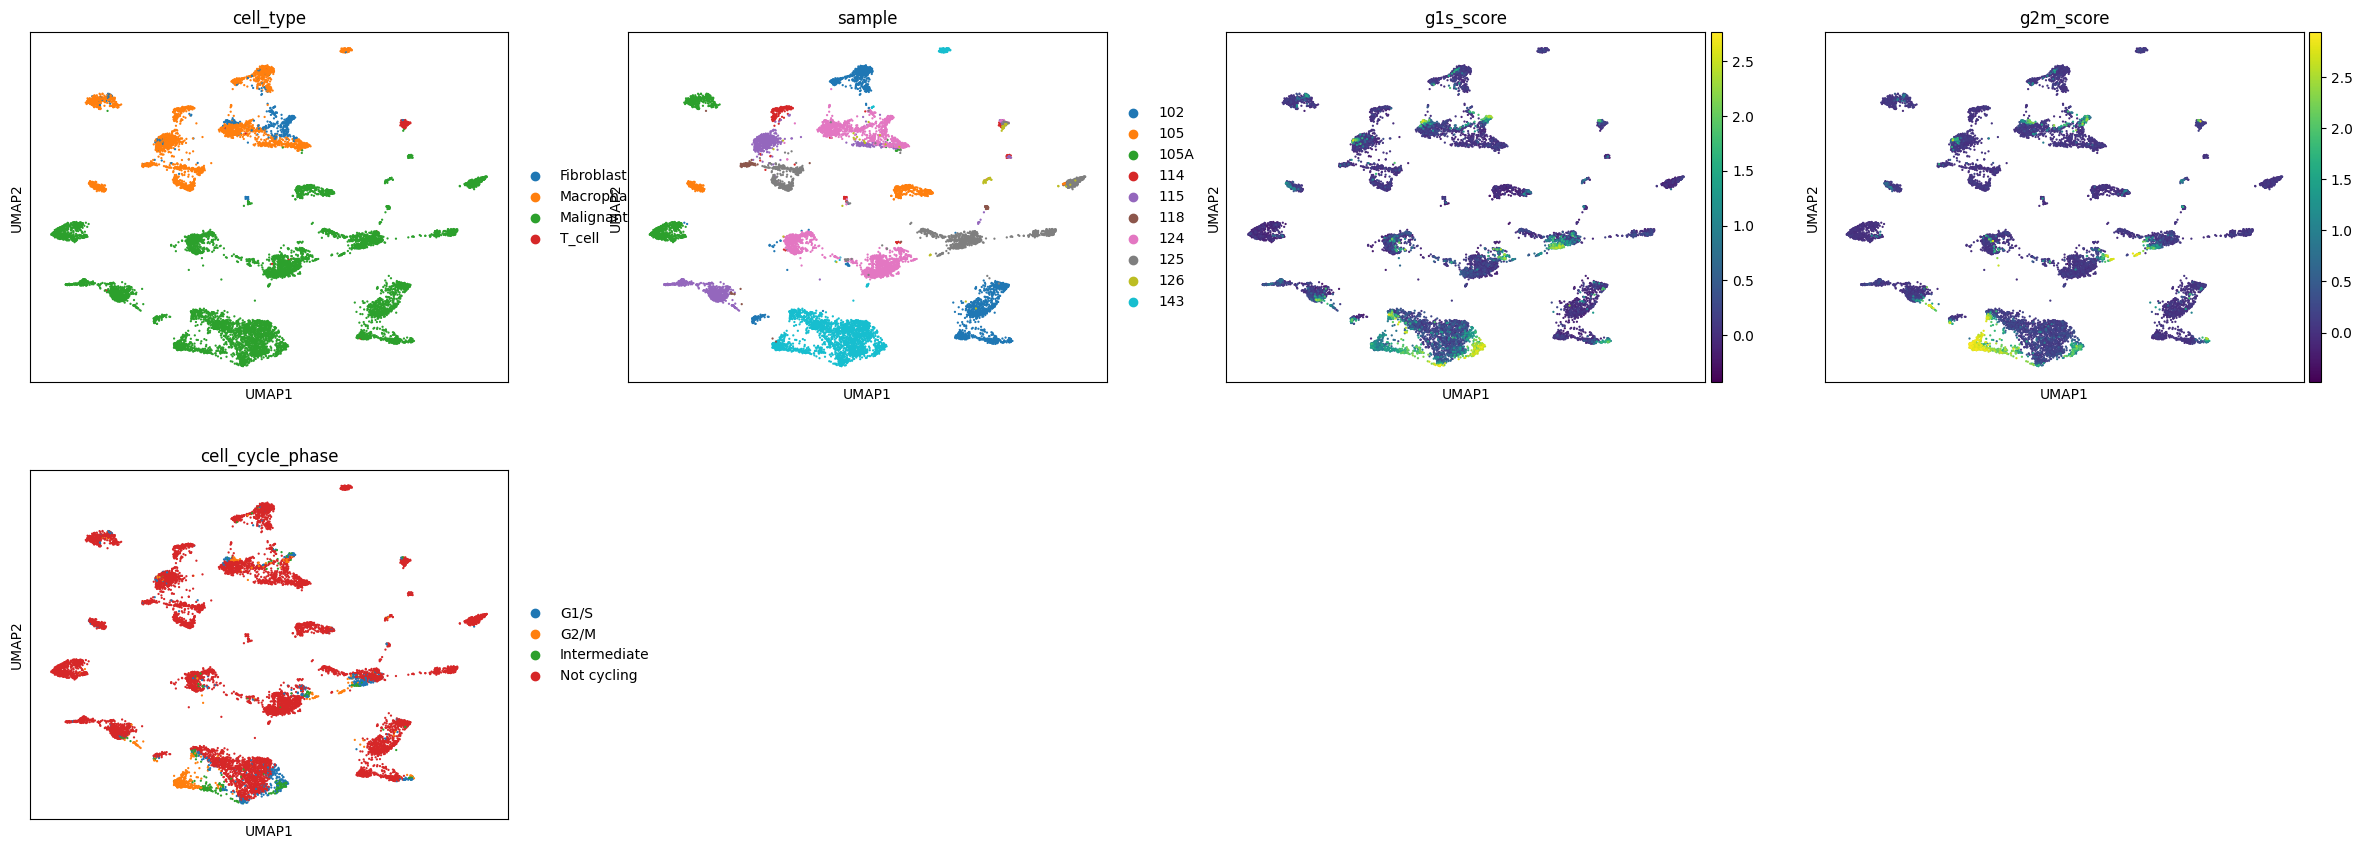

In [95]:
# plot umap
umap_data_array = adata.obs[['umap1', 'umap2']].values
adata.obsm['umap'] = umap_data_array

sc.pl.embedding(adata, basis="umap", color=["cell_type", "sample", "g1s_score", "g2m_score", "cell_cycle_phase"])


## Preprocess adata to work with scorer

- normalise
- log transfoer
- do NOT scale/center !!!

In [96]:
# Step 1: Normalize per cell (to make library sizes comparable)
sc.pp.normalize_total(adata, target_sum=1e4)

# Step 2: Log-transform (compress the dynamic range)
sc.pp.log1p(adata)

# Step 3: Store the normalized data for downstream analysis
adata.raw = adata

# Load broad postive genes

In [97]:
positive_genes_df = pd.read_csv(config["data_paths"]["broad_positive_genes"])
display(positive_genes_df)

broad_positive_gene_list = positive_genes_df.gene.to_list()

,gene,geneset_count,is_guaranteed,label,geneset_percent
0,CDK1,98,True,positive,33.676976
1,FAM64A,98,True,positive,33.676976
2,H2AFZ,98,True,positive,33.676976
3,HIST1H4C,98,True,positive,33.676976
4,HN1,98,True,positive,33.676976
...,...,...,...,...,...
7289,ZSCAN20,1,False,ambigous,0.343643
7290,ZSCAN22,1,False,ambigous,0.343643
7291,ZSCAN9,1,False,ambigous,0.343643
7292,ZSWIM4,1,False,ambigous,0.343643


# Cell cycling cells

Find which cells are in the cell cycle process:
- adata alredy contains this info
- just to be sure recalcuate, how?
    - take genesets related to cell cycle
    - claulte module

In [108]:
# sho what cell cyel ingo is alredy present
display(adata.obs.cell_cycle_phase.unique())

# read VERY spefiic gene set for ccylcing cells
metaprograms_df = pd.read_excel(config["data_paths"]["metaprograms_3CA"])
display(metaprograms_df.head(2))

strict_G2_M_genes = set(metaprograms_df["MP1 Cell Cycle - G2/M"])
strict_G1_S_genes = set(metaprograms_df["MP2 Cell Cycle - G1/S"])
strict_cc_genes = strict_G2_M_genes.union(strict_G1_S_genes)
len(strict_cc_genes)

# calculate module for each cell
sc.tl.score_genes(
    adata=adata, 
    gene_list=list(strict_G2_M_genes),
    ctrl_size=10, #ATTENTION: not default
    gene_pool=None, #all genes
    n_bins=25,
    use_raw=False, #use lognorm
    score_name="G2_M_score"
)
sc.tl.score_genes(
    adata=adata, 
    gene_list=list(strict_G1_S_genes),
    ctrl_size=10, #ATTENTION: not default
    gene_pool=None, #all genes
    n_bins=25,
    use_raw=False, #use lognorm
    score_name="G1_S_score"
)
sc.tl.score_genes(
    adata=adata, 
    gene_list=list(strict_cc_genes),
    ctrl_size=10, #ATTENTION: not default
    gene_pool=None, #all genes
    n_bins=25,
    use_raw=False, #use lognorm
    score_name="cc_score"
)

display(adata.obs)

['Not cycling', 'G1/S', 'G2/M', 'Intermediate']
Categories (4, object): ['G1/S', 'G2/M', 'Intermediate', 'Not cycling']

,MP1 Cell Cycle - G2/M,MP2 Cell Cycle - G1/S,MP3 Cell Cylce HMG-rich,MP4 Chromatin,MP5 Cell cycle single-nucleus,MP6 Stress 1,MP7 Hypoxia,MP8 Stress (in vitro),MP9 Stress 2,MP10 Proteasomal degradation,...,MP58 Metal-response,MP59 PDAC-related 1,MP60 PDAC-related 2,MP61 PDAC-related 3,MP62 PDAC-related 4,MP63 PDAC-related 5,MP64 Adherens,MP65 Cholesterol Homeostasis,MP66 Unassigned 1,MP67 Unassigned 2
0,HMGB2,PCNA,STMN1,GOLGB1,ATAD2,EGR1,NDRG1,DDIT3,HSPH1,CCT5,...,DDIT4,CEACAM6,PLAUR,GPX2,CP,NEAT1,DHCR24,SQLE,AC010343.1,CCNL2
1,UBE2C,FEN1,TUBA1B,ASH1L,BRCA1,FOS,BNIP3,SLC3A2,HSPA1A,CCT7,...,MT1E,S100P,UPP1,ANXA10,MMP7,AGRN,JAG1,HMGCS1,AKAP9,CDK5RAP3


,sample,cell_type,complexity,umap1,umap2,g1s_score,g2m_score,cell_cycle_phase,mp_top_score,mp_top,mp_assignment,G2_M_score,G1_S_score,cc_score
cell_name,,,,,,,,,,,,,,
102_1,102,Malignant,3101,20.8435,-12.0361,-0.0434,0.1245,Not cycling,1.1889,Oligo Progenitor,Oligo Progenitor,-0.191751,-0.194485,-0.143495
102_2,102,Malignant,2366,-12.6327,-18.9353,1.1051,0.2308,G1/S,1.4424,Cell Cycle - G1/S,Cell Cycle - G1/S,0.163840,0.339566,0.283513
102_4,102,Malignant,1217,-11.9102,-18.0864,-0.1774,-0.0561,Not cycling,1.4340,Stress,NaN,-0.001897,-0.092791,-0.028245
102_5,102,Malignant,2285,20.1392,-11.5944,-0.1211,-0.0473,Not cycling,2.6042,Oligo Progenitor,Oligo Progenitor,-0.084880,-0.148911,-0.083688
102_7,102,Malignant,1725,17.2946,-16.4965,-0.0337,-0.0467,Not cycling,1.5445,NPC Glioma,NPC Glioma,-0.115314,-0.076304,-0.017338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105_D2_139,105,Malignant,1029,28.8941,9.4308,-0.2548,-0.0581,Not cycling,4.9770,Oligo normal,NaN,0.041792,-0.159762,-0.060061
105_D2_148,105,Malignant,1035,29.0623,9.6065,-0.2660,-0.0584,Not cycling,5.2820,Oligo normal,NaN,-0.061972,-0.024138,-0.014598
105_D2_189,105,Macrophage,1126,-20.2338,8.0329,-0.0252,0.0550,Not cycling,1.0727,MAC3,MAC3,-0.057758,-0.110788,-0.038753


In [109]:
# chekc if new scores correlate wiht old ones
adata.obs[["cc_score", "G1_S_score", "G2_M_score", "g1s_score", "g2m_score"]].corr()


,cc_score,G1_S_score,G2_M_score,g1s_score,g2m_score
cc_score,1.000000,0.850225,0.931232,0.737153,0.840819
G1_S_score,0.850225,1.000000,0.638081,0.856298,0.541081
G2_M_score,0.931232,0.638081,1.000000,0.590825,0.909485
g1s_score,0.737153,0.856298,0.590825,1.000000,0.626030
g2m_score,0.840819,0.541081,0.909485,0.626030,1.000000


# Calculate postive genes modules